In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

# GP regresion with Guy

In [2]:
npts = 10 # 10 to keep computation time reasonable
x = np.sort(np.random.randn(npts)) * 2.3 + 0.8 # make it look reasonably like our stellar data


In [3]:
def func(x): 
    return np.poly1d([0.2, 1.0, 0.5])(x)  
# a polynomial and a straight line fit

In [4]:
y_true = func(x)
y_err = np.ones_like(x) * 0.2
y_obs = y_true + np.random.randn(npts) * y_err

<ErrorbarContainer object of 3 artists>

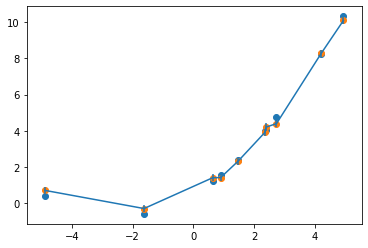

In [5]:
fig, ax = plt.subplots()
ax.scatter(x, y_true)
ax.scatter(x, y_obs)
ax.errorbar(x, y_obs, yerr=y_err, linestyle=None)

In [6]:
model = pm.Model()
with model:
    # y = m*x + c
    m = pm.Normal('m', 0, 1e3)
    c = pm.Normal('c', 0, 1e3)
    
    fit = pm.Deterministic('fit', m*x+c)
    
    # what we expect to see:
    obs = pm.Normal('obs', fit, y_err, observed=y_obs)
    
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c, m]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1845.82draws/s]


In [7]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
m,0.966,0.023,0.929,1.011,0.001,0.001,631.0,631.0,634.0,563.0,1.00
c,2.364,0.073,2.220,2.488,0.003,0.002,533.0,533.0,533.0,590.0,1.00
fit[0],-2.350,0.159,-2.638,-2.055,0.007,0.005,569.0,569.0,573.0,439.0,1.00
fit[1],0.797,0.096,0.613,0.972,0.004,0.003,548.0,548.0,547.0,442.0,1.00
fit[2],2.978,0.067,2.849,3.092,0.003,0.002,540.0,540.0,536.0,541.0,1.01
fit[3],3.232,0.065,3.106,3.345,0.003,0.002,547.0,547.0,541.0,598.0,1.00
fit[4],3.781,0.064,3.659,3.896,0.003,0.002,570.0,570.0,569.0,660.0,1.01
fit[5],4.641,0.066,4.518,4.773,0.003,0.002,602.0,599.0,589.0,719.0,1.00
fit[6],4.680,0.067,4.553,4.808,0.003,0.002,602.0,601.0,585.0,719.0,1.00
fit[7],5.006,0.069,4.877,5.139,0.003,0.002,649.0,648.0,620.0,659.0,1.00


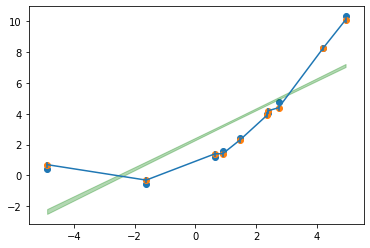

In [8]:
fig, ax = plt.subplots()
ax.scatter(x, y_true)
ax.scatter(x, y_obs)
ax.errorbar(x, y_obs, yerr=y_err, linestyle=None)

# have a look at the fit vs the data
mean = np.mean(trace['fit'], axis=0)
std = np.std(trace['fit'], axis=0)

ax.fill_between(x, mean-std, mean+std, alpha=0.3, color='g')

In [9]:
model_gp = pm.Model()
X = x[:, None]

with model_gp:
    # now with a GP and some priors
    m = pm.Normal('m', 0, 1e3)
    c = pm.Normal('c', 0, 1e3)
    
    cov_func = pm.gp.cov.ExpQuad(1, ls = 1.0) # this is the squared exponential covariance function
    gp = pm.gp.Latent(cov_func=cov_func) # makes the mean function 0
    
    f = gp.prior('f', X=X) # produces some x drawn from the GP
    
    fit = pm.Deterministic('fit', m*x + c + f)
    
    # what we expect to see:
    obs = pm.Normal('obs', fit, y_err, observed=y_obs)
    
    trace = pm.sample()
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f_rotated_, c, m]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:07<00:00, 264.70draws/s]


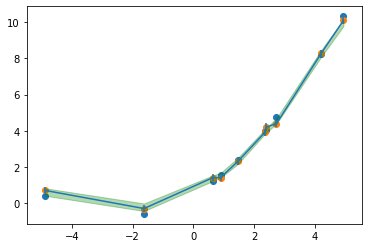

In [10]:
fig, ax = plt.subplots()
ax.scatter(x, y_true)
ax.scatter(x, y_obs)
ax.errorbar(x, y_obs, yerr=y_err, linestyle=None)

mean = np.mean(trace['fit'], axis=0)
std = np.std(trace['fit'], axis=0)

ax.fill_between(x, mean-std, mean+std, alpha=0.3, color='g')

In [11]:
X_new = np.linspace(-8, 8, 50)[:, None]

with model_gp:
    f_new = gp.conditional('f_new', X_new)
    pred_samples = pm.sample_posterior_predictive(trace, vars=[f_new, fit], samples=1000)

100%|██████████| 1000/1000 [00:11<00:00, 83.87it/s]


Text(0, 0.5, '$\\mathcal{GP}$ contribution')

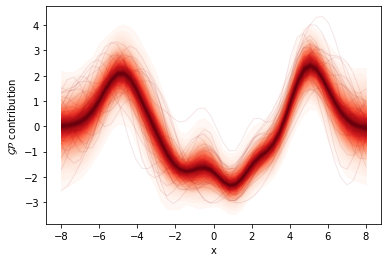

In [12]:
from pymc3.gp.util import plot_gp_dist
fig, ax = plt.subplots()
plot_gp_dist(ax, pred_samples['f_new'], X_new);
ax.set_xlabel('x')
ax.set_ylabel(r'$\mathcal{GP}$ contribution')

sigma - variation we're willing to accept; can have a tight prior, not gonna have huge mHz variation on dNu for example